In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 60.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 26.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=98fa3e0a346b7109aeecc736a2f7c368925fc298f898a0fd090b902204ff51f5
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


## _*Quantum SVM algorithm:  multiclass classifier extension*_

A multiclass extension works in conjunction with an underlying binary (two classes) classifier to provide multiclass classification.
Here we choose the `Wine` dataset which has 3 classes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler

from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute

In [3]:
# function to get sklearn wine dataset, take the desired number of samples and features, scale it and plot it

def wine(training_size, test_size, n_features, plot_data=False):
    """ returns wine dataset """
    data, target = load_wine(return_X_y=True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=test_size, random_state=42)

    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    pca = PCA(n_components=n_features).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler(feature_range=(-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    sample_train = sample_train[:training_size, :]
    label_train = label_train[:training_size]
    sample_test = sample_test[:training_size, :]
    label_test = label_test[:training_size]

    if plot_data:
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            raise NameError('Matplotlib not installed. Please install it before plotting')
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Wine dataset")
        plt.show()

    return sample_train, label_train, sample_test, label_test

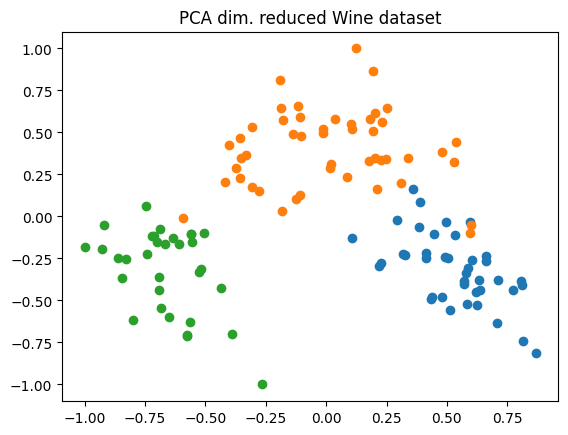

In [4]:
train_data, train_labels, test_data, test_labels = wine(
    training_size=120,
    test_size=20, n_features=2, plot_data=True
)

In [5]:
feature_map = ZZFeatureMap(2)

fidelity = ComputeUncompute(sampler=Sampler())
new_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

# you can use One-Versus-One classification ('ovo') or One-Versus-Rest ('ovr')
qsvc = QSVC(quantum_kernel=new_kernel, decision_function_shape='ovr')

qsvc.fit(train_data, train_labels)
print(f'Training set accuracy {qsvc.score(train_data, train_labels)}; test set accuracy: {qsvc.score(test_data, test_labels)}')

<ipython-input-5-b602f871a13c>:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  fidelity = ComputeUncompute(sampler=Sampler())


Training set accuracy 0.8916666666666667; test set accuracy: 0.8


In [6]:
! pip freeze | grep qiskit

qiskit==1.4.0
qiskit-algorithms==0.3.1
qiskit-machine-learning==0.8.2
